#### Analyzing interstellar reddening and calculating synthetic photometry


In [13]:
#Install dependencies
!pip install astropy
!pip install synphot
!pip install dust_extinction
!pip install astroquery

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 4.5 MB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 802 kB 78.1 MB/s eta 0:00:01
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=6bf06b13fd16b0338b2c5c6716079db00202eb77f2fc66d37680d745b0aebf0f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/94/c8/82/dd8db7264e72fa5ae829c4b14280cb83db3b8479b5958dc937
Successfully built mimeparse
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [51]:
#Import Libraries
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import astropy.units as u
from astropy.table import Table
from dust_extinction.parameter_averages import CCM89, F99, F04, O94
from synphot import units, config
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.reddening import ExtinctionCurve
from astroquery.simbad import Simbad
from astroquery.mast import Observations
import astropy.visualization

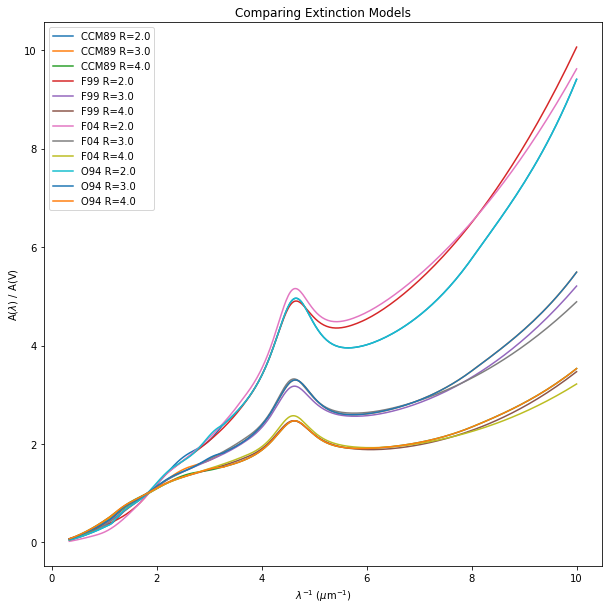

In [52]:
# Create wavelengths array.
wav = np.arange(0.1, 3.0, 0.001)*u.micron

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for model in [CCM89, F99, F04,O94]:
    for R in (2.0,3.0,4.0):
        # Initialize the extinction model
        ext = model(Rv=R)
        plt.plot(1/wav, ext(wav), label=model.name+' R='+str(R))
        
plt.xlabel('$\lambda^{-1}$ ($\mu$m$^{-1}$)')
plt.ylabel('A($\lambda$) / A(V)')
plt.legend(loc='best')
plt.title('Comparing Extinction Models')


plt.show()

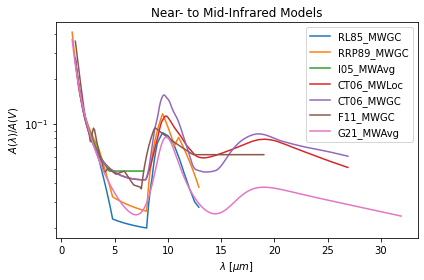

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from dust_extinction.averages import (RL85_MWGC,
                                      RRP89_MWGC,
                                      I05_MWAvg,
                                      CT06_MWLoc,
                                      CT06_MWGC,
                                      F11_MWGC,
                                      G21_MWAvg)

fig, ax = plt.subplots()

# generate the curves and plot them
x = 1.0 / (np.arange(1.0, 40.0 ,0.1) * u.micron)

models = [RL85_MWGC, RRP89_MWGC, I05_MWAvg, CT06_MWLoc, CT06_MWGC,
          F11_MWGC, G21_MWAvg]

for cmodel in models:
  ext_model = cmodel()
  indxs, = np.where(np.logical_and(
     x.value >= ext_model.x_range[0],
     x.value <= ext_model.x_range[1]))
  yvals = ext_model(x[indxs])
  ax.plot(1.0 / x[indxs], yvals, label=ext_model.__class__.__name__)

ax.set_yscale("log")
ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'$A(\lambda)/A(V)$')
ax.set_title('Near- to Mid-Infrared Models')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [15]:
download_dir = pathlib.Path('~/Data/').expanduser()
download_dir.mkdir(exist_ok=True)

obsTable = Observations.query_object("HD 147933", radius="1 arcsec")
obsTable_spec = obsTable[obsTable['dataproduct_type'] == 'spectrum']
obsTable_spec

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str11,str12,str13,str6,str16,str16,str21,str32,str31,float64,float64,str8,str19,int64,float64,float64,float64,float64,float64,str117,float64,str25,str6,int64,str23309,str137,str137,str6,bool,float64,str8,float64
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05490,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.7773264,46135.7787093,119.48,185000100000.0,334994200000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05490.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05490.mxhi.gz,PUBLIC,--,5885.0,349209,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05491,246.39607641879502,-23.4459600461498,spectrum,Theodore P. Snow,2,46135.8042014,46135.8083623,359.506,185000500000.0,334994900000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396076418795 -23.4459600461498 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05491.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05491.mxhi.gz,PUBLIC,--,5885.0,349210,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05492,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.830544,46135.8319269,119.48,185004300000.0,334993600000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05492.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05492.mxhi.gz,PUBLIC,--,5885.0,349211,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05493,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.8570949,46135.8609098,329.605,185000400000.0,334994500000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05493.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05493.mxhi.gz,PUBLIC,--,5885.0,349212,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05494,246.39607641879502,-23.4459600461498,spectrum,Theodore P. Snow,2,46135.8850463,46135.8864292,119.48,185004200000.0,334993300000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396076418795 -23.4459600461498 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05494.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05494.mxhi.gz,PUBLIC,--,5885.0,349213,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05495,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.9142708,46135.9180857,329.605,185000900000.0,334995500000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05495.gif,http://archive.stsci.edu/missions/iue/data/lwp/05000/lwp05495.mxhi.gz,PUBLIC,--,5885.0,349214,0.0
science,IUE,--,LWP,--,HIGH DISP,UV,HD 147933,--,lwp05496,246.396176503177,-23.4459596019354,spectrum,Theodore P. Snow,2,46135.9434838,46135.944696,104.735,185000400000.0,334994400000.0,Interstellar Lines and Ultraviolet Extinction in Dark Clouds,nan,IMGTS,--,--,CIRCLE ICRS 246.396176503177 -23.4459596019354 0.00300694444444,http://archive.stsci.edu/browse/previews/iue/mx/lwp/05000/gif/lwp05496.gif,http://archive.stsci.edu/missi

In [16]:
obsids = obsTable_spec[39]['obsid']
dataProductsByID = Observations.get_product_list(obsids)
manifest = Observations.download_products(dataProductsByID, 
                                          download_dir=str(download_dir))

In [17]:
t_lwr = Table.read(download_dir / 'mastDownload/IUE/lwr05639/lwr05639mxlo_vo.fits')
print(t_lwr)

      WAVE [562]              FLUX [562]         ... QUALITY [562]
       Angstrom         erg / (Angstrom cm2 s)   ...              
--------------------- -------------------------- ... -------------
1851.4327 .. 3348.901 2.08651e-10 .. 7.39839e-11 ...       0 .. 16


In [18]:
wav_UV = t_lwr['WAVE'][0,].quantity
UVflux = t_lwr['FLUX'][0,].quantity

In [19]:
custom_query = Simbad()
custom_query.add_votable_fields('fluxdata(U)','fluxdata(B)','fluxdata(V)')
phot_table=custom_query.query_object('HD 147933')
Umag=phot_table['FLUX_U']
Bmag=phot_table['FLUX_B']
Vmag=phot_table['FLUX_V']

In [20]:
wav_U = 0.3660 * u.micron 
zeroflux_U_nu = 1.81E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_B = 0.4400 * u.micron
zeroflux_B_nu = 4.26E-23 * u.Watt/(u.m*u.m*u.Hz)
wav_V = 0.5530 * u.micron
zeroflux_V_nu = 3.64E-23 * u.Watt/(u.m*u.m*u.Hz)

In [21]:
zeroflux_U = zeroflux_U_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_U))
zeroflux_B = zeroflux_B_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_B))
zeroflux_V = zeroflux_V_nu.to(u.erg/u.AA/u.cm/u.cm/u.s, 
                              equivalencies=u.spectral_density(wav_V))

In [22]:
Uflux = zeroflux_U * 10.**(-0.4*Umag)
Bflux = zeroflux_B * 10.**(-0.4*Bmag)
Vflux = zeroflux_V * 10.**(-0.4*Vmag)

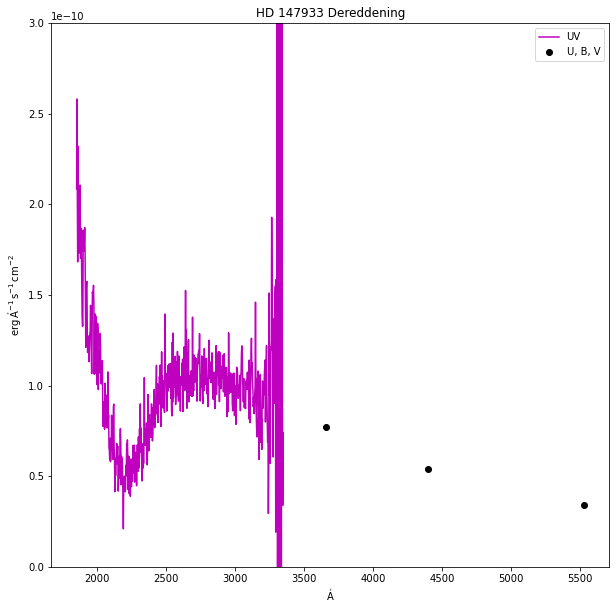

In [55]:
astropy.visualization.quantity_support()


f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

plt.plot(wav_UV,UVflux,'m',label='UV')
plt.plot(wav_V,Vflux,'ko',label='U, B, V')
plt.plot(wav_B,Bflux,'ko')
plt.plot(wav_U,Uflux,'ko')
plt.legend(loc='best')
plt.ylim(0,3E-10)
plt.title('HD 147933 Dereddening')
plt.show()

In [57]:
Rv = 5.0  # Usually around 3, but about 5 for this star.
Ebv = 0.5
ext = F04(Rv=Rv)

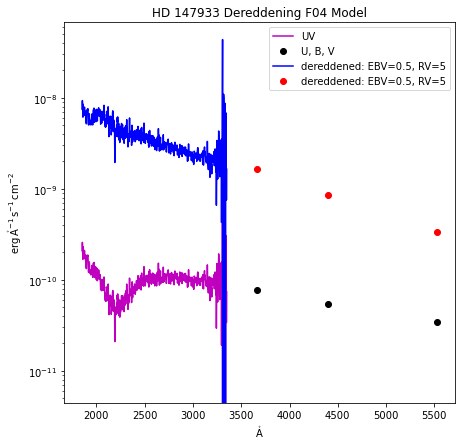

In [70]:

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

plt.semilogy(wav_UV,UVflux,'m',label='UV')
plt.semilogy(wav_V,Vflux,'ko',label='U, B, V')
plt.semilogy(wav_B,Bflux,'ko')
plt.semilogy(wav_U,Uflux,'ko')

plt.semilogy(wav_UV,UVflux/ext.extinguish(wav_UV,Ebv=Ebv),'b',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_V,Vflux/ext.extinguish(wav_V,Ebv=Ebv),'ro',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_B,Bflux/ext.extinguish(wav_B,Ebv=Ebv),'ro')
plt.semilogy(wav_U,Uflux/ext.extinguish(wav_U,Ebv=Ebv),'ro')

plt.legend(loc='best')
plt.title('HD 147933 Dereddening F04 Model')
plt.show()

In [60]:
Rv = 5.0  # Usually around 3, but about 5 for this star.
Ebv = 0.5
ext = O94(Rv=Rv)

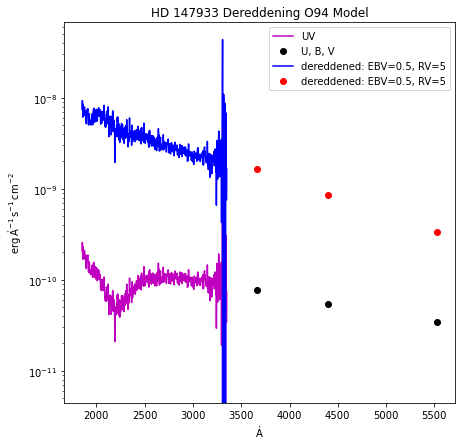

In [69]:

f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

plt.semilogy(wav_UV,UVflux,'m',label='UV')
plt.semilogy(wav_V,Vflux,'ko',label='U, B, V')
plt.semilogy(wav_B,Bflux,'ko')
plt.semilogy(wav_U,Uflux,'ko')

plt.semilogy(wav_UV,UVflux/ext.extinguish(wav_UV,Ebv=Ebv),'b',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_V,Vflux/ext.extinguish(wav_V,Ebv=Ebv),'ro',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_B,Bflux/ext.extinguish(wav_B,Ebv=Ebv),'ro')
plt.semilogy(wav_U,Uflux/ext.extinguish(wav_U,Ebv=Ebv),'ro')

plt.legend(loc='best')
plt.title('HD 147933 Dereddening O94 Model')
plt.show()

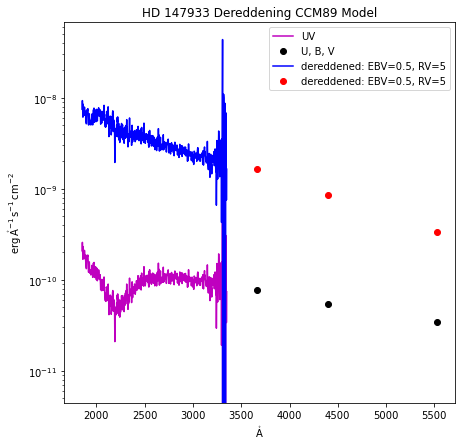

In [67]:
Rv = 5.0
Ebv = 0.5
ext = CCM89(Rv=Rv)
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

plt.semilogy(wav_UV,UVflux,'m',label='UV')
plt.semilogy(wav_V,Vflux,'ko',label='U, B, V')
plt.semilogy(wav_B,Bflux,'ko')
plt.semilogy(wav_U,Uflux,'ko')

plt.semilogy(wav_UV,UVflux/ext.extinguish(wav_UV,Ebv=Ebv),'b',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_V,Vflux/ext.extinguish(wav_V,Ebv=Ebv),'ro',
             label='dereddened: EBV=0.5, RV=5')
plt.semilogy(wav_B,Bflux/ext.extinguish(wav_B,Ebv=Ebv),'ro')
plt.semilogy(wav_U,Uflux/ext.extinguish(wav_U,Ebv=Ebv),'ro')

plt.legend(loc='best')
plt.title('HD 147933 Dereddening CCM89 Model')
plt.show()

In [71]:
config.conf.vega_file = 'http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file = 'http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

<Figure size 432x432 with 0 Axes>

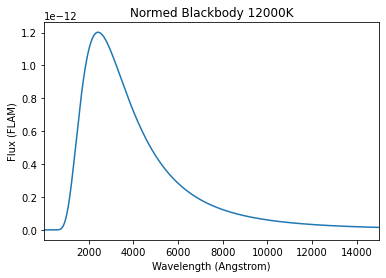

In [94]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=12000)
# sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)


f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody 12000K')

<Figure size 432x432 with 0 Axes>

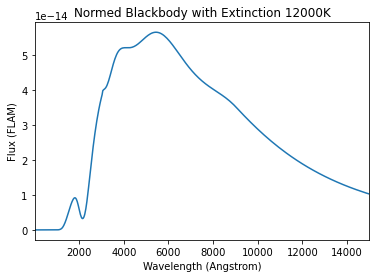

In [95]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = O94(Rv=3.1)
Av = 2.
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

# Create a wavelength array. 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table.
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction 12000K')

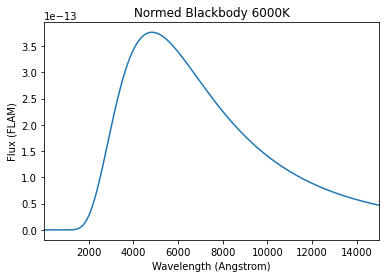

In [93]:
# First, create a blackbody at some temperature.
sp = SourceSpectrum(BlackBodyNorm1D, temperature=6000)
# sp.plot(left=1, right=15000, flux_unit='flam', title='Blackbody')

# Get the Vega spectrum as the zero point flux.
vega = SourceSpectrum.from_vega()
# vega.plot(left=1, right=15000)

# Normalize the blackbody to some chosen magnitude, say V = 10.
vmag = 10.
v_band = SpectralElement.from_filter('johnson_v')
sp_norm = sp.normalize(vmag * units.VEGAMAG, v_band, vegaspec=vega)
sp_norm.plot(left=1, right=15000, flux_unit='flam', title='Normed Blackbody 6000K')

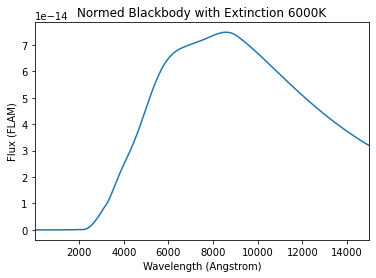

In [92]:
# Initialize the extinction model and choose the extinction, here Av = 2.
ext = O94(Rv=3.1)
Av = 2.

# Create a wavelength array. 
wav = np.arange(0.1, 3, 0.001)*u.micron

# Make the extinction model in synphot using a lookup table.
ex = ExtinctionCurve(ExtinctionModel1D, 
                     points=wav, lookup_table=ext.extinguish(wav, Av=Av))
sp_ext = sp_norm*ex
sp_ext.plot(left=1, right=15000, flux_unit='flam',
            title='Normed Blackbody with Extinction 6000K')